In [1]:
import xarray as xr
import xgcm
import numpy as np
import xroms
import matplotlib.pyplot as plt
import xroms.datasets

# How to calculate with `xarray` and `xroms`

Here we demonstrate a number of calculations built into `xroms`, through accessors to `DataArrays` and `Datasets`.

## `xarray` Datasets
Use an `xarray` accessor in `xroms` to easily perform calculations with syntax 

    ds.xroms.[method]
    
Importantly, the `xroms` accessor to a `Dataset` is initialized with an `xgcm` grid object, stored at `ds.xroms.grid`, which is used to perform the basic grid calculations. More on this under "How to set up grid" below.

The built-in native calculations are properties of the `xroms` accessor and are not functions.

The accessor functions can take in the horizontal then vertical grid label you want the calculation to be on as options:

    ds.xroms.ddz('u', hcoord='rho', scoord='s_rho')  # to make sure result is on rho horizontal grid and s_rho vertical grid, a function
    
or

    ds.xroms.dudz  # return on native grid it is calculated on, a property

Other inputs are available for functions when the calculation involves a derivative and there is a choice for how to treat the boundary (`hboundary` and `hfill_value` for horizontal calculations and `sboundary` and `sfill_value` for vertical calculations). More information on those inputs can be found in the docs for `xgcm` such as under found under:

    ds.xroms.grid.interp?


## `xarray` DataArrays

A few of the more basic methods in `xroms` are available to `DataArrays` too. If the Dataset was read in using an `xroms` load function, any of the `DataArrays` has its grid stored in `da.attrs['grid']`. So, the built-in `xroms` methods for `DataArrays` do not require the grid object to be input.

    ds.temp.xroms.to_grid(hcoord='psi', scoord='s_w')

## Attributes

The intent of `xroms` is to be use `xarray` Datasets and DataArrays for calculations. `xroms` provides attributes as metadata to track calculations, provide context, and to be used as indicators for plots. The `xgcm` grid object that is used in many calculations is also passed around as an attribute in DataArrays.

The option to always keep attributes in `xarray` is turned on in the call to `xroms` because the functionality is assumed.

## `cf-xarray`

Some functionality is added by using the package `cf-xarray`. Necessary attributes are added to datasets when the following call is run:

    ds, xgrid = xroms.roms_dataset(ds)

### Load in data

More information at in [input/output notebook](io.ipynb)

In [21]:
ds = xr.open_dataset("ocean_his_0150.nc")
ds

<xarray.Dataset>
Dimensions:      (tracer: 6, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 191,
                  xi_rho: 671, eta_u: 191, xi_u: 670, eta_v: 190, xi_v: 671,
                  eta_psi: 190, xi_psi: 670, ocean_time: 100)
Coordinates:
  * s_rho        (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w          (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    x_rho        (eta_rho, xi_rho) float64 ...
    y_rho        (eta_rho, xi_rho) float64 ...
    x_u          (eta_u, xi_u) float64 ...
    y_u          (eta_u, xi_u) float64 ...
    x_v          (eta_v, xi_v) float64 ...
    y_v          (eta_v, xi_v) float64 ...
    x_psi        (eta_psi, xi_psi) float64 ...
    y_psi        (eta_psi, xi_psi) float64 ...
  * ocean_time   (ocean_time) datetime64[ns] 2009-11-19T12:00:00 ... 2009-12-06
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u,
                                eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/71)
    ntimes       int32 ...
    ndtfast      int32 ...
    dt           float64 ...
    dtfast       float64 ...
    dstart       datetime64[ns] ...
    nHIS         int32 ...
    ...           ...
    dye_03       (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    dye_04       (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    sustr        (ocean_time, eta_u, xi_u) float32 ...
    svstr        (ocean_time, eta_v, xi_v) float32 ...
    bustr        (ocean_time, eta_u, xi_u) float32 ...
    bvstr        (ocean_time, eta_v, xi_v) float32 ...
Attributes: (12/29)
    file:              ocean_his_0150.nc
    format:            netCDF-3 classic file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             Texas and Louisiana Shelf case (Nesting)
    rst_file:          ocean_rst.nc
    ...                ...
    compiler_command:  /g/software/openmpi/1.4.3/intel/bin/mpif90
    compiler_flags:    -heap-arrays -fp-model precise -assume 2underscores -c...
    tiling:            016x032
    history:           ROMS/TOMS, Version 3.4, Sunday - December 4, 2011 -  7...
    ana_file:          /scratch/zhangxq/projects/txla_nesting6/Functionals/an...
    CPP_options:       TXLA, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, BULK_FLUX...

In [22]:
ds["Vtransform"]

<xarray.DataArray 'Vtransform' ()>
[1 values with dtype=int32]
Attributes:
    long_name:  vertical terrain-following transformation equation

In [23]:
keep_vertical_coords = True
keep_horizontal_coords = True
keep_coord_mask = True
standard_names = ["potential temperature", "salinity", "u-momentum component", "v-momentum component"]

In [24]:
    to_merge = []
    if "angle" in ds.variables:
        to_merge.append(ds["angle"])

    if keep_vertical_coords:
        # Deal with vertical coord decoding

        # standard_names associated with vertical coordinates
        s_standard_names_list = [
            "ocean_s_coordinate_g1",
            "ocean_s_coordinate_g2",
            "ocean_sigma_coordinate",
        ]

        # want to find the vertical coord standard_names variables AND those with formula_terms
        # which should be identical but seems like a good check
        def formula_terms(value):
            """weed out Nones"""
            return value is not None

        def s_standard_names(value):
            """loop over s coord standard_names"""
            return value in s_standard_names_list

        # get a Dataset with these coordinates
        v_grid_ds = ds.filter_by_attrs(
            formula_terms=formula_terms, standard_name=s_standard_names
        )
        if len(v_grid_ds.variables) > 0:
            to_merge.append(v_grid_ds)

        # For the vertical related coords (e.g. for ROMS these will be `s_rho` and `s_w`
        # gather all formula term variable names to bring along
        formula_vars = []
        for coord in v_grid_ds.coords:
            # It's possible to have coordinates of the filtered variables which do not define
            # formula_terms, like in FVCOM.
            if "formula_terms" in v_grid_ds[coord].attrs:
                formula_vars.extend(list(v_grid_ds[coord].cf.formula_terms.values()))
        formula_vars = list(set(formula_vars))
        if len(formula_vars) > 0:
            to_merge.append(ds[formula_vars])

    if keep_horizontal_coords:
        # Get a ds for coordinates
        h_coords_standard_names = [
            "longitude",
            "latitude",
        ]
        h_grid_ds = ds.filter_by_attrs(
            standard_name=lambda v: v in h_coords_standard_names
        )
        if len(h_grid_ds.variables) > 0:
            to_merge.append(h_grid_ds)
        # if model_type_guess == "FVCOM":
        #     if "x" in ds.variables and "y" in ds.variables:
        #         to_merge.append(ds[["x", "y"]])
        #     if "xc" in ds.variables and "yc" in ds.variables:
        #         to_merge.append(ds[["xc", "yc"]])
        # elif model_type_guess == "SELFE":
        #     if "x" in ds.variables and "y" in ds.variables:
        #         to_merge.append(ds[["x", "y"]])

    if keep_horizontal_coords and keep_coord_mask:
        # Keep coordinate masks
        mask_ds = ds.filter_by_attrs(flag_meanings="land water")
        if len(mask_ds.variables) > 0:
            to_merge.append(mask_ds)

    # Also get a Dataset for all the requested variables
    def f_standard_names(value):
        """loop over standard_names list"""
        return value in standard_names

    to_merge.append(ds.filter_by_attrs(long_name=f_standard_names))

    # Combine
    ds2 = xr.merge(to_merge)


In [25]:
ds2["Vtransform"] = ds["Vtransform"]
ds2["pm"] = ds["pm"]
ds2["pn"] = ds["pn"]


In [26]:
ds2.isel(ocean_time=slice(0,2)).xroms.subset(X=slice(350,650)).to_netcdf("ROMS_example_full_grid.nc")

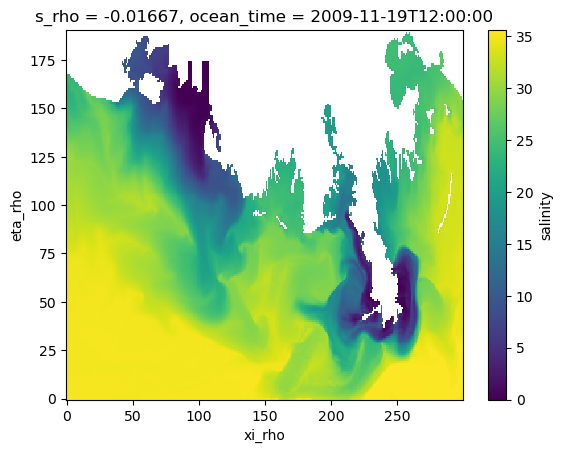

In [37]:
ds[["u","v","salt","zeta"]].isel(ocean_time=slice(0,2)).xroms.subset(X=slice(350,650))["salt"].isel(ocean_time=0, s_rho=-1).plot()# .nbytes/1e6


In [45]:
ds["u"]

<xarray.DataArray 'u' (ocean_time: 100, s_rho: 30, eta_u: 191, xi_u: 670)>
[383910000 values with dtype=float32]
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    x_u         (eta_u, xi_u) float64 ...
    y_u         (eta_u, xi_u) float64 ...
  * ocean_time  (ocean_time) datetime64[ns] 2009-11-19T12:00:00 ... 2009-12-06
Dimensions without coordinates: eta_u, xi_u
Attributes:
    long_name:  u-momentum component
    units:      meter second-1
    time:       ocean_time
    field:      u-velocity, scalar, series

In [2]:
# ds = xr.open_zarr("http://xpublish-ciofs.srv.axds.co/datasets/ciofs_hindcast/zarr/", chunks={}, consolidated=True)
# ds

ds = xr.tutorial.open_dataset("ROMS_example.nc", chunks={"ocean_time": 1})
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 2, s_rho: 30, eta_rho: 191, xi_rho: 371)
Coordinates:
    Cs_r        (s_rho) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 371), meta=np.ndarray>
    hc          float64 ...
    h           (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 371), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(191, 371), meta=np.ndarray>
    Vtransform  int32 ...
  * ocean_time  (ocean_time) datetime64[ns] 2001-08-01 2001-08-08
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 191, 371), meta=np.ndarray>
    zeta        (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 191, 371), meta=np.ndarray>
Attributes: (12/34)
    file:              ../output_20yr_obc/2001/ocean_his_0015.nc
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             TXLA ROMS hindcast run with dyes and oxygen
    rst_file:          ../output_20yr_obc/2001/ocean_rst.nc
    ...                ...
    compiler_flags:    -heap-arrays -fp-model fast -mt_mpi -ip -O3 -msse2 -free
    tiling:            010x012
    history:           Tue Jul 24 11:04:43 2018: /opt/nco/ncks -D 4 -t 8 /cop...
    ana_file:          /home/d.kobashi/TXLA_ROMS_reana/Functionals/ana_btflux...
    CPP_options:       TXLA2, ANA_BPFLUX, ANA_BSFLUX, ANA_BTFLUX, ANA_NUDGCOE...
    NCO:               netCDF Operators version 4.7.6-alpha04 (Homepage = htt...

In [2]:
# ds = xr.open_dataset("ROMS_example_full_grid.nc", chunks={"ocean_time": 1})
ds = xroms.datasets.fetch_ROMS_example_full_grid()
ds

HTTPError: 404 Client Error: Not Found for url: https://github.com/axiom-data-science/xroms/raw/%7Bversion_dev%7D/data/ROMS_example_full_grid.nc

In [28]:
%%time
ds, xgrid = xroms.roms_dataset(ds, include_cell_volume=True)

CPU times: user 373 ms, sys: 5.95 ms, total: 378 ms
Wall time: 384 ms


In [29]:
# add grid to xrom accessor explicitly
ds.xroms.set_grid(xgrid)

In [30]:
ds.xroms.xgrid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   xi_rho --> inner
  * inner    xi_u --> center
Y Axis (not periodic, boundary=None):
  * center   eta_rho --> inner
  * inner    eta_v --> center
Z Axis (not periodic, boundary=None):
  * center   s_rho --> outer
  * outer    s_w --> center

In [2]:
# Helpful to have local file for this
url = 'http://barataria.tamu.edu:8080/thredds/fileServer/forecast_latest/txla2_his_a_latest.nc'
fname = url.split('/')[-1]
chunks = {'ocean_time': 1}

import os
if os.path.exists(fname):
    ds = xroms.open_netcdf(fname, chunks=chunks)
else:
    from subprocess import call
    call(['wget', url])
    ds = xroms.open_netcdf(fname, chunks=chunks)
    
# Alternatively, use file through thredds:
# loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/forecast_latest/txla2_his_f_latest.nc'
# chunks = {'ocean_time':1}
# ds = xr.open_dataset(loc, chunks=chunks)

--2023-05-22 13:26:39--  http://barataria.tamu.edu:8080/thredds/fileServer/forecast_latest/txla2_his_a_latest.nc
Resolving barataria.tamu.edu (barataria.tamu.edu)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘barataria.tamu.edu’


FileNotFoundError: [Errno 2] No such file or directory: b'/Users/kthyng/projects/xroms/examples/txla2_his_a_latest.nc'

## `xgcm` grid and extra ROMS coordinates

### How to set up grid

The package `xcgm` has many nice grid functions for ROMS users, however, a bit of set up is required to connect from ROMS to MITgcm output. This grid set up does that.

The `grid` object contains metrics (X, Y, Z) with distances for each grid ('dx', 'dx_u', 'dx_v', 'dx_psi', and 'dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v', 'dz_psi', 'dz_w_psi'), and all of these as grid coordinates too. 

Coordinates are added to the dataset when `xroms.open_netcdf`, `xroms.open_mfnetcdf`, or `xroms.open_zarr` are used and the grid object is stored in the `DataArray`  attributes at `da.attrs['grid']`, and in the Dataset through the accessor (`ds.xroms.grid`).

You can also explicitly set up the grid with:

> ds, grid = xroms.roms_dataset(ds)

This process sets up all sorts of useful coordinate variables.

### Grid lengths

Distances between grid nodes on every ROMS grid are calculated in the setup process using `xroms` (that is, by reading in your output using as `xroms` load function or subsequently running `xroms.roms_dataset`). 

* Horizontal grids:
 * inverse distances between nodes are also given in an analogous way (*i.e.*, `ds.pm` and `ds.pn_psi`)
 * distances between nodes are given in meters by dx's and dy's stored in ds, such as: `ds.dx` for the `rho` grid and `ds.dy_psi` for the `psi` grid, calculated from inverse distances
* Vertical grids:
 * There are lazily-evaluated z-coordinates for both `rho` and `w` vertical grids for each horizontal grid.
 * There are also arrays of z distances between nodes, called dz's, available for each combination of grids. For example, there is `ds.dz_u` for z distances on the `u` horizontal and `rho` vertical grid, and there is `ds.dz_w_v` for z distances on the `v` horizontal and `w` vertical grid. These are `[ocean_time x s_* x eta_* x xi_*]` arrays.
 * Arrays of z distances relative to a sea level of 0 are also available. They have analogous names to the previous entries but with "0" on the end. They are computationally faster to use because they do not vary in time. They are also less accurate for this reason but it depends on your use as to how much that matters.

### Grid areas

* Horizontal
  * rho grid `ds.dA`, psi grid `ds.dA_psi`, u grid `ds.dA_u`, v grid `ds.dA_v`
* Vertical
  * These aren't built in but can easily be calculated. For example, for cell areas in the x direction on the rho horizontal and rho vertical grids: `ds.dx * ds.dz`.

### Grid volumes

Time varying: All 8 combinations of 4 horizontal grids and 2 vertical grids are available, such as: `ds.dV` (rho horizontal, rho vertical), and `ds.dV_w_v` (w vertical, v horizontal). 

A user can easily calculate the same but for time-constant dz's, for example as: 

    ds['dV_w'] = ds.dx * ds.dy * ds.dz_w0  # w vertical, rho horizontal, constant in time
    
To calculate the full domain volume in time, you can do:

In [31]:
ds.dV.sum(('s_rho', 'eta_rho', 'xi_rho'));

In [9]:
ds.dV.cf.sum(('Z', 'Y', 'X'));  # with cf-xarray accessor

## Change grids

A ROMS user frequently needs to move between horizontal and vertical grids, so it is built into many of the function wrappers, but you can also do it as a separate function. It can also be done directly to `Datasets` with the `xroms` accessor. Here we change salinity from its default grids to be on the psi grid horizontally and the s_w grid vertically:

In [32]:
%%time
ds.xroms.to_grid('salt', 'psi', 's_w');

CPU times: user 41 ms, sys: 2.32 ms, total: 43.3 ms
Wall time: 42.1 ms


You can also go to the original `xroms` function and avoid the `xarray` accessor if you prefer, though the point of the accessor approach (that is, `ds.xroms...`) is to be easier to remember and less code to write generally. Here is the equivalent call to the accessor, using the same defaults:

    xroms.to_grid(ds["salt"], xgrid,
                  hcoord="psi", scoord="s_w",
                  hboundary="extend", hfill_value=None,
                  sboundary="extend", sfill_value=None,
                  )

## Dimension ordering convention

By convention, ROMS DataArrays should be in the order ['T', 'Z', 'Y', 'X'], for however many of these dimensions they contain. The following function does this for you:

In [11]:
%%time
xroms.order(ds.temp);  # function call
ds.temp.xroms.order();  # accessor

CPU times: user 27 ms, sys: 2.5 ms, total: 29.5 ms
Wall time: 31.2 ms


## Basic computations

These are all functions.

### `xarray`

Many [computations](http://xarray.pydata.org/en/stable/computation.html) are built into `xarray` itself. Often it is possible to input the dimension over which to perform a computation by name, such as:

    arr.sum(dim="xi_rho")

or 

    arr.sum(dim=("xi_rho","eta_rho"))

Note that many basic `xarray` calculations should be used with caution when using with ROMS output, since a ROMS grid can be stretched both horizontally and vertically. When using these functions, consider if your calculation should account for variable grid cell distances, areas, or volumes. Additionally, it is straight-forward to use basic grid functions from `xarray` on a ROMS time dimension (resampling, differentiation, interpolation, etc), however, be careful before using these functions on spatial dimensions for the same reasons as before.

In [12]:
%%time
ds.salt.mean(dim=("xi_rho","eta_rho"));

CPU times: user 1.77 s, sys: 65.9 ms, total: 1.83 s
Wall time: 1.84 s


`cf-xarray`

In [13]:
%%time
ds.salt.cf.mean(("Y","X"));

CPU times: user 1.7 s, sys: 56.7 ms, total: 1.76 s
Wall time: 1.76 s


#### `xroms` grid-based metrics

Spatial metrics that account for the variable grid cell sizing in ROMS (both curvilinear horizontal and s vertical) are available by wrapping `xgcm` functions. These also have the additional benefit that the user can change grids and attributes are tracked. The available functions are:

* gridsum
* gridmean

Example usage:

    xroms.gridsum(ds.temp, xgrid, dim)

    ds['temp'].xroms.gridsum(xgrid, dim)

where dimension names in the `xgcm` convention are 'Z', 'Y', or 'X'. `dim` can be a string, list, or tuple of combinations of these names for dimensions to average over.

##### sum

In [6]:
%%time
ds.u.xroms.gridsum(xgrid, ('Y','Z'));

ValueError: Error parsing datetime string "Y" at position 0

mean

In [15]:
%%time
ds.v.xroms.gridmean(xgrid, ('Y','X'));

/Users/kthyng/miniconda3/envs/XROMS/lib/python3.10/site-packages/xgcm/grid.py:1645: UserWarning: Metric at ('ocean_time', 's_rho', 'eta_v', 'xi_rho') being interpolated from metrics at dimensions ('eta_rho', 'xi_rho'). Boundary value set to 'extend'.
  warnings.warn(


CPU times: user 3.61 s, sys: 148 ms, total: 3.76 s
Wall time: 3.79 s


## Derivatives

### Vertical

In [16]:
%%time
ds.xroms.ddz('salt');  # Dataset

CPU times: user 24.4 s, sys: 1.05 s, total: 25.5 s
Wall time: 25.7 s


In [17]:
%%time
xroms.ddz(ds.salt, xgrid);  # No accessor

CPU times: user 26.2 s, sys: 1.11 s, total: 27.3 s
Wall time: 27.5 s


There are more options available for this call:

In [18]:
%%time
ds.xroms.ddz('salt', hcoord='psi', scoord='s_rho', sboundary='extend', sfill_value=np.nan);  # Dataset

CPU times: user 43.9 s, sys: 1.71 s, total: 45.6 s
Wall time: 46 s


In [19]:
%%time
xroms.ddz(ds.salt, xgrid, hcoord='psi', scoord='s_rho', sboundary='extend', sfill_value=np.nan);  # No accessor

CPU times: user 54 s, sys: 1.64 s, total: 55.6 s
Wall time: 56.1 s


### Horizontal

In [20]:
%%time
ds.xroms.ddxi('u');  # horizontal xi-direction gradient
ds.xroms.ddeta('u');  #  horizontal eta-direction gradient

NotImplementedError: Cannot chunk along a core dimension for a grid ufunc which has a signature which includes one of the axis positions ['inner', 'outer'].Consider rechunking to a single chunk along this dimension if possible.

In [21]:
%%time
dtempdxi, dtempdeta = xroms.hgrad(ds.temp, xgrid)

NotImplementedError: Cannot chunk along a core dimension for a grid ufunc which has a signature which includes one of the axis positions ['inner', 'outer'].Consider rechunking to a single chunk along this dimension if possible.

In [ ]:
%%time
xroms.ddxi(ds.temp, xgrid);
xroms.ddeta(ds.temp, xgrid);

### Time

Use `xarray` directly for this.

In [ ]:
ddt = ds.chunk({'ocean_time': 2}).differentiate('ocean_time', datetime_unit='s')

## Built-in Physical Calculations

These are all properties of the accessor, so should be called without (). Demostrated below are the calculations using the accessor and not using the accessor.

### Horizontal speed

In [ ]:
ds.xroms.speed;

In [ ]:
xroms.speed(ds.u, ds.v, ds.u.attrs['grid']); 

### Kinetic energy

In [ ]:
ds.xroms.KE;

In [ ]:
speed = xroms.speed(ds.u, ds.v, ds.u.attrs['grid']);
xroms.KE(ds.rho0, speed);

### Geostrophic velocities

In [ ]:
ds.xroms.ug;
ds.xroms.vg;

In [ ]:
ug, vg = xroms.uv_geostrophic(ds.zeta, ds.f, ds.zeta.attrs['grid']);

### Eddy kinetic energy (EKE)

In [ ]:
ds.xroms.EKE;

In [ ]:
ug, vg = xroms.uv_geostrophic(ds.zeta, ds.f, ds.zeta.attrs['grid']);
xroms.EKE(ug, vg, ug.attrs['grid']);

### Vertical shear

Since it is a common use case, there are specific methods to return the u and v components of vertical shear on their own grids. These are just available for Datasets.

In [ ]:
ds.xroms.dudz;
ds.xroms.dvdz;

In [ ]:
xroms.dudz(ds.u, ds.u.attrs['grid']);
xroms.dvdz(ds.v, ds.v.attrs['grid']);

If we want to calculate something with both, we need them on the same grid. For this, we can input the desired resultant grid:

In [ ]:
ds.xroms.dudz.xroms.to_grid(hcoord='rho', scoord='s_rho')**2 + ds.xroms.dvdz.xroms.to_grid(hcoord='rho', scoord='s_rho')**2;

Or in this case, the magnitude of the vertical shear is also a built-in derived variable for the `xroms` accessor:

In [ ]:
ds.xroms.vertical_shear;

In [ ]:
dudz = xroms.dudz(ds.u, ds.u.attrs['grid']);
dvdz = xroms.dvdz(ds.v, ds.v.attrs['grid']);
xroms.vertical_shear(dudz, dvdz, dudz.attrs['grid']);

### Vertical vorticity

In [ ]:
xroms.relative_vorticity(ds.u, ds.v, ds.u.attrs['grid']);

### Ertel potential vorticity

The accessor assumes you want the Ertel potential vorticity of the buoyancy:

In [ ]:
ds.xroms.ertel;

In [ ]:
sig0 = xroms.potential_density(ds.temp, ds.salt);
buoyancy = xroms.buoyancy(sig0, rho0=ds.rho0);
xroms.ertel(buoyancy, ds.u, ds.v, ds.f, ds.u.attrs['grid'], scoord='s_w');

Alternatively, the user can access the original function and use a different tracer for this calculation, and can return the result on a different vertical grid, for example:

In [ ]:
xroms.ertel(ds.dye_01, ds.u, ds.v, ds.f, ds.u.attrs['grid'], scoord='s_w');

### Density

In [ ]:
ds.xroms.rho;

In [ ]:
xroms.density(ds.temp, ds.salt);

### Potential density

In [ ]:
ds.xroms.sig0;

In [ ]:
xroms.potential_density(ds.temp, ds.salt);

### Buoyancy

In [ ]:
ds.xroms.buoyancy;

In [ ]:
sig0 = xroms.potential_density(ds.temp, ds.salt);
xroms.buoyancy(sig0);

### Buoyancy frequency

Also called vertical buoyancy gradient.

In [ ]:
ds.xroms.N2;

In [ ]:
rho = xroms.density(ds.temp, ds.salt)  # calculate rho if not in output
xroms.N2(rho, rho.attrs['grid']);

### Horizontal buoyancy gradient 

In [ ]:
ds.xroms.M2;

In [ ]:
rho = xroms.density(ds.temp, ds.salt)  # calculate rho if not in output
xroms.M2(rho, rho.attrs['grid']);

### Mixed layer depth

This is not a property since the threshold is a parameter.

In [ ]:
ds.xroms.mld(thresh=0.03);

In [ ]:
sig0 = xroms.potential_density(ds.temp, ds.salt);
xroms.mld(sig0, ds.h, ds.mask_rho, thresh=0.03);

## Time-based calculations including climatologies

### Rolling averages in time

Here is an example of computing a rolling average in time.

More information about rolling operations [is available](http://xarray.pydata.org/en/stable/computation.html#rolling-window-operations).

In [ ]:
roll = ds.salt.rolling(ocean_time=3, center=True, min_periods=2).mean()
roll.isel(s_rho=-1, eta_rho=50, xi_rho=40).plot()
ds.salt.isel(s_rho=-1, eta_rho=50, xi_rho=40).plot()

### Resampling in time

Can't have any chunks in the time dimension to do this. More info: http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html

#### Upsample

Upsample to a higher resolution in time. Makes sense to interpolate to fill in data when upsampling, but can also forward or backfill, or just add nan's.

In [ ]:
dstest = ds.resample(ocean_time='30min', restore_coord_dims=True, keep_attrs=True).interpolate()

Plot to visually inspect results

In [ ]:
ds.salt.cf.isel(Y=30, X=20, Z=-1, T=slice(0,10)).plot(marker='o')
dstest.salt.cf.isel(Y=30, X=20, Z=-1).isel(ocean_time=slice(0,20)).plot(marker='x')

#### Downsample

Resample down to lower resolution in time. This requires appending a method to aggregate the extra data, such as a `mean`. Note that other options can be used to shift the result within the interval of aggregation in various ways.

In [ ]:
dstest = ds.resample(ocean_time='3H').mean()

In [ ]:
ds.salt.isel(eta_rho=30, xi_rho=20, s_rho=-1, ocean_time=slice(0,10)).plot(marker='o')
dstest.salt.isel(eta_rho=30, xi_rho=20, s_rho=-1, ocean_time=slice(0,5)).plot(marker='x')

#### Seasonal average, over time

This is an example of [resampling](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.resample.html).

    da.cf.resample({'T': [time frequency string]}).reduce([aggregation function])
    
For example, calculate the mean temperature every quarter in time with the following:

    ds.temp.cf.resample({'T': 'QS'}).reduce(np.mean)

or the aggregation function can be appended on the end directly with:

    ds.temp.cf.resample({'T': 'QS'}).mean()

The result of this calculation is a time series of downsampled chunks of output in time, the frequency of which is selected by input "time frequency string", and aggregated by input "aggregation function".

Examples of the time frequency string are:
* "QS": quarters, starting in January of each year and averaging three months.
  * Also available are selections like "QS-DEC", quarters but starting with December to better align with seasons. Other months are input options as well.
* "MS": monthly
* "D": daily
* "H": hourly
* Many more options are given [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

Examples of aggregation functions are:
* np.mean
* np.max
* np.min
* np.sum
* np.std

Result of downsampling a 4D salt array from hourly to 6-hourly, for example, gives: `[ocean_time x s_rho x eta_rho x xi_rho]`, where `ocean_time` has about 1/6 of the number of entries reflecting the aggregation in time.

In [ ]:
ds.temp.cf.resample(indexer={'T': '6H'}).reduce(np.mean);

Use the following to calculate a seasonal or quarterly average over time (noting that this dataset has only a day worth of output so there is only 1 quarter):

In [ ]:
ds.temp.cf.resample(indexer={'T': 'QS'}).reduce(np.mean);

### Seasonal mean over all available time

This is how to average over the full dataset period by certain time groupings using xarray `groupby` which is like pandas version. In this case we show the seasonal mean averaged across the full model time period. The syntax for this is:

    da.salt.cf.groupby('T.[time string]').reduce([aggregation function])

For example, to average salt by season:

    da.salt.cf.groupby('T.season').reduce(np.mean)

or

    da.salt.cf.groupby('T.season').mean()

Options for the time string include:
* 'season'
* 'year'
* 'month'
* 'day'
* 'hour'
* 'minute'
* 'second'
* 'dayofyear'
* 'week'
* 'dayofweek'
* 'weekday'
* 'quarter'

More information about options for time (including "derived" datetime coordinates) is [here](https://xarray.pydata.org/en/v0.16.0/time-series.html#datetime-components).

Examples of aggregation functions are:
* np.mean
* np.max
* np.min
* np.sum
* np.std

Result of averaging over seasons for a 4D salt array returns, for example: `[season x s_rho x eta_rho x xi_rho]`, where `season` has 4 entries, each covering 3 months of the year.

In [ ]:
# this example has only 1 season because it is a short example file
ds.temp.cf.groupby('T.season').mean();